In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [2]:
data = pd.read_csv("spam.csv", encoding='latin1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [3]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)

data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)

In [5]:
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0, 0.5, 'Number of Data points')

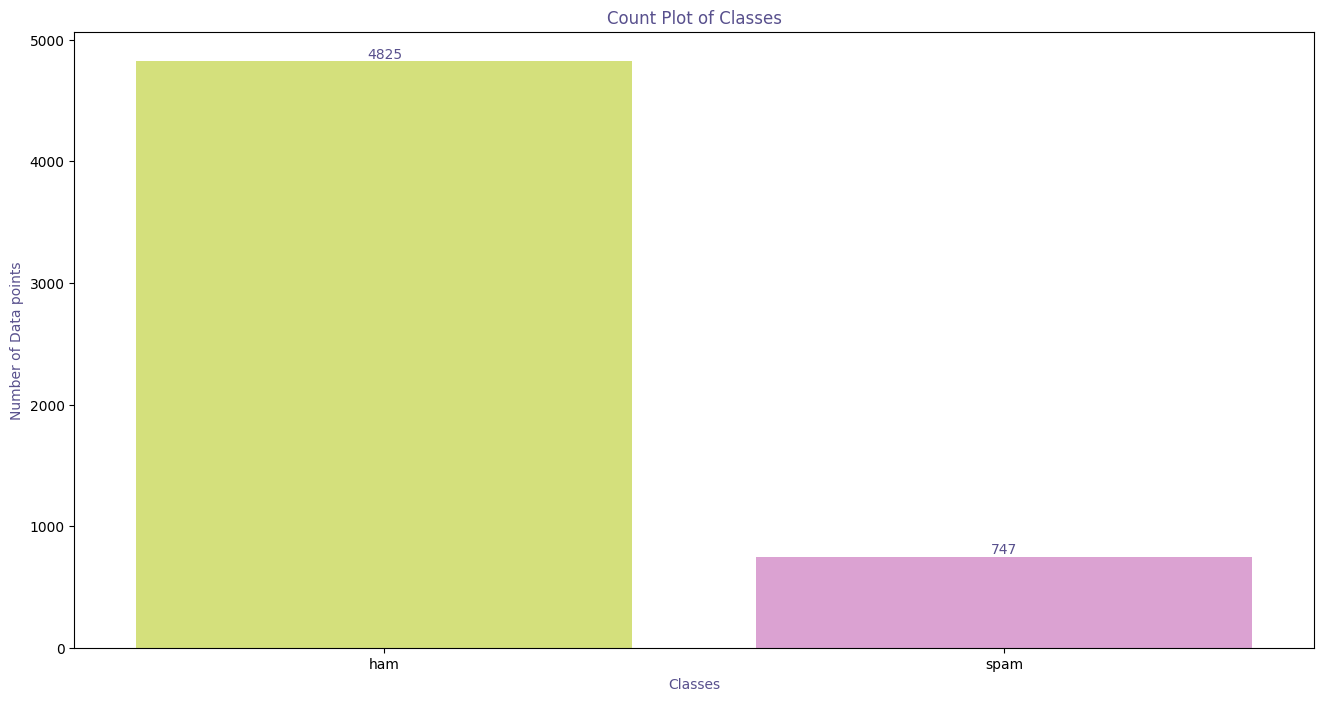

In [6]:
cols = ["#E1F16B", "#E598D8"]

plt.figure(figsize=(16, 8))
fg = sns.countplot(data=data, x="Target", hue="Target", palette=cols, legend=False)

for p in fg.patches:
    height = p.get_height()
    x_position = p.get_x() + p.get_width() / 2
    fg.text(x_position, height + 0.5, str(int(height)), ha='center', va='bottom', color="#58508d")


fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")


In [7]:
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.699390,13.741932,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.996411,1.520159,1.0,1.0,1.5,2.0,38.0


In [8]:
data.head()

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


<Figure size 1200x800 with 0 Axes>

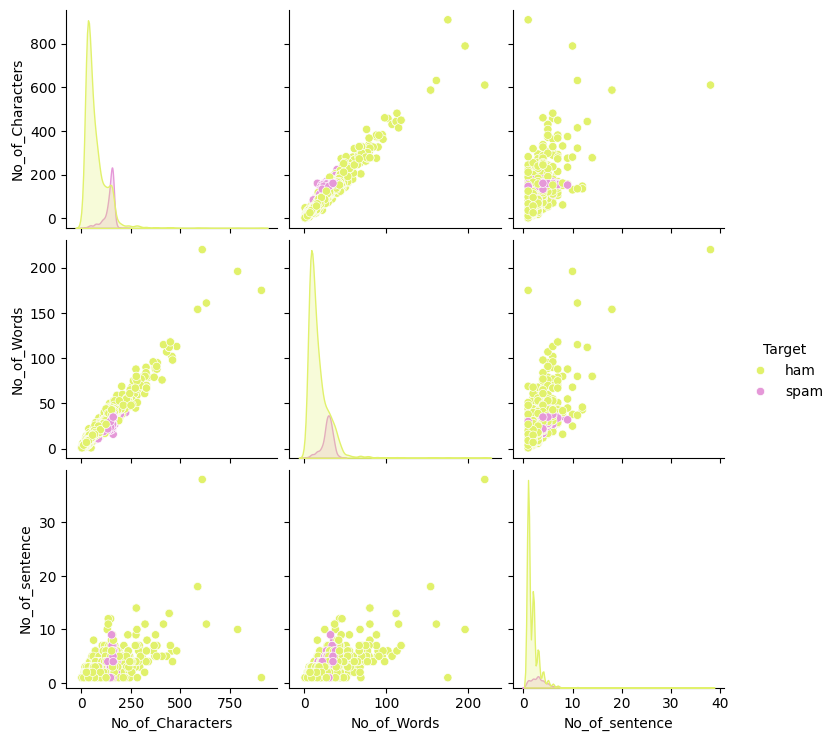

In [9]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [10]:
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 1200x800 with 0 Axes>

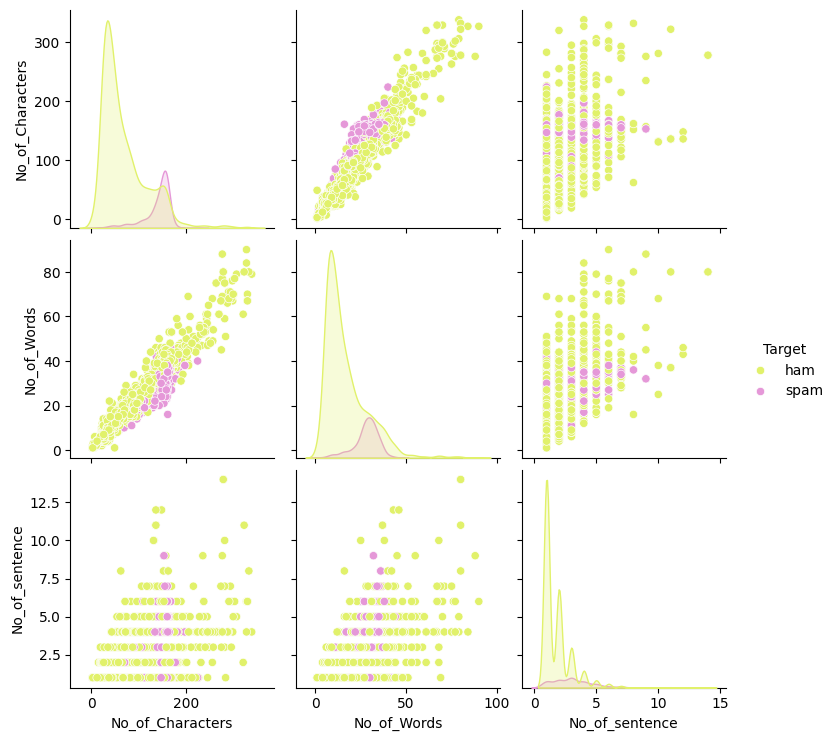

In [11]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [12]:
data = data[(data["No_of_Words"]<50)]
data.shape

(5475, 5)

<Figure size 1200x800 with 0 Axes>

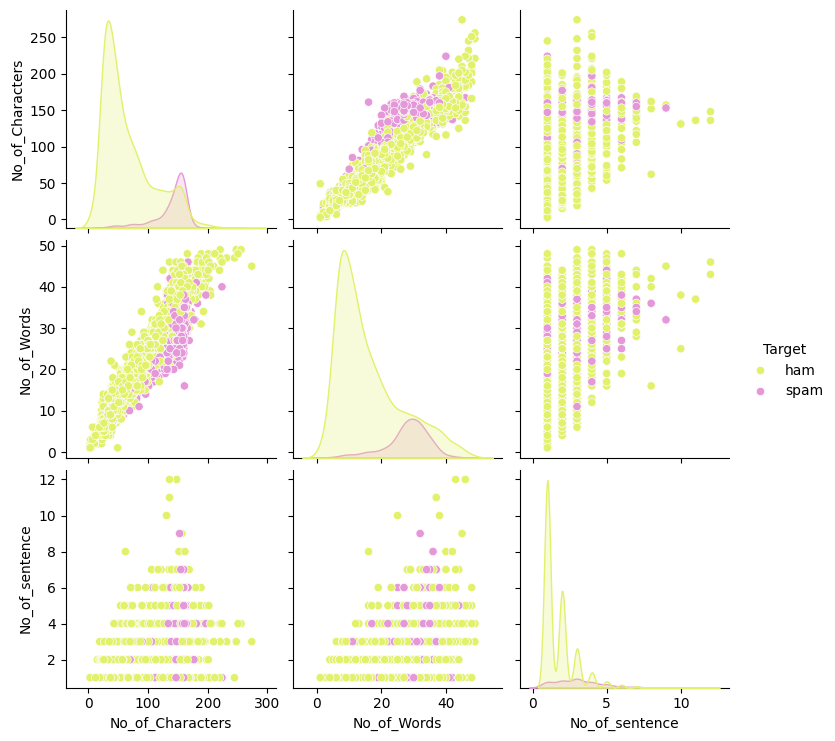

In [13]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [14]:
data = data[(data["No_of_sentence"]<10)]
data.shape

(5467, 5)

<Figure size 1200x800 with 0 Axes>

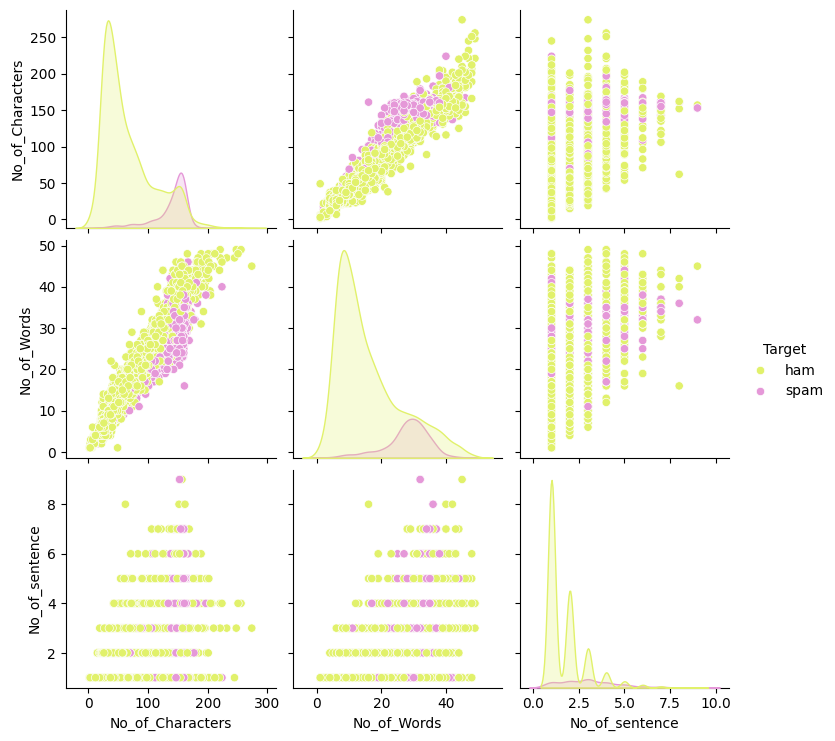

In [15]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

In [16]:
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [17]:
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) 
    sms = sms.lower() 
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [18]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [19]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [20]:
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [21]:
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [22]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [23]:
X.shape

(5467, 6307)

In [24]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

In [25]:
data

,Target,Text,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[go, until, jurong, point, crazy, available, o...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"
...,...,...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,35,4,this is the nd time we have tried contact u u ...,"[this, is, the, nd, time, we, have, tried, con...","[nd, time, tried, contact, u, u, pound, prize,...","[nd, time, try, contact, u, u, pound, prize, c..."
5568,0,Will Ì_ b going to esplanade fr home?,37,9,1,will b going to esplanade fr home,"[will, b, going, to, esplanade, fr, home]","[b, going, esplanade, fr, home]","[b, go, esplanade, fr, home]"
5569,0,"Pity, * was in mood for that. So...any other s...",57,15,2,pity was in mood for that so any other suggest...,"[pity, was, in, mood, for, that, so, any, othe...","[pity, mood, suggestions]","[pity, mood, suggestions]"
5570,0,The guy did some bitching but I acted like i'd...,125,27,1,the guy did some bitching but i acted like i d...,"[the, guy, did, some, bitching, but, i, acted,...","[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, somethi..."


In [26]:
y = data["Target"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4373, 6307)
(1094, 6307)
(4373,)
(1094,)


In [45]:
classifiers = [
    MultinomialNB(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC(),
    LinearSVC(),  
    LogisticRegression(max_iter=1000),
    GradientBoostingClassifier(),
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    XGBClassifier(eval_metric='logloss') 
]
for cls in classifiers:
    cls.fit(X_train, y_train)

pipe_dict = {
    0: "NaiveBayes",
    1: "RandomForest",
    2: "KNeighbours",
    3: "SVC",
    4: "LinearSVC",
    5: "LogisticRegression",
    6: "GradientBoosting",
    7: "AdaBoost",
    8: "DecisionTree",
    9: "XGBoost"
}


In [46]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train, y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967296 
RandomForest: 0.978959 
KNeighbours: 0.910130 
SVC: 0.976903 
LinearSVC: 0.984677 
LogisticRegression: 0.957693 
GradientBoosting: 0.969353 
AdaBoost: 0.926594 
DecisionTree: 0.961578 
XGBoost: 0.976902 


In [47]:
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)


In [48]:
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}

Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours", "SVC", "LinearSVC", "LogisticRegression", "GradientBoosting", "AdaBoost", "DecisionTree", "XGBoost"])

In [49]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.787671,0.881226,0.977148,0.992911
RandomForest,1.000000,0.828767,0.906367,0.977148,0.992911
KNeighbours,1.000000,0.390411,0.561576,0.977148,0.992911
SVC,0.992063,0.856164,0.919118,0.977148,0.992911
LinearSVC,0.984615,0.876712,0.927536,0.977148,0.992911
LogisticRegression,0.982456,0.767123,0.861538,0.977148,0.992911
GradientBoosting,0.974576,0.787671,0.871212,0.977148,0.992911
AdaBoost,0.864583,0.568493,0.685950,0.977148,0.992911
DecisionTree,0.869863,0.869863,0.869863,0.977148,0.992911
XGBoost,0.961832,0.863014,0.909747,0.977148,0.992911


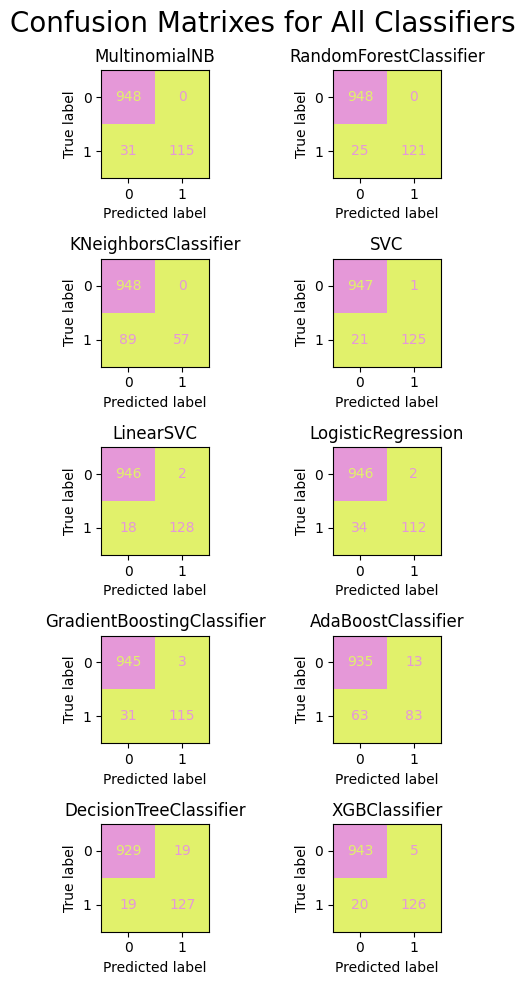

In [50]:
from sklearn.metrics import confusion_matrix

cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(5,10))

fig.suptitle("Confusion Matrixes for All Classifiers", fontsize=20)


for cls, ax in zip(classifiers, axes.flatten()):
    y_pred = cls.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls.classes_ if hasattr(cls, "classes_") else [0,1])
    disp.plot(cmap=cmap, ax=ax, colorbar=False)
    ax.title.set_text(type(cls).__name__)

    
plt.tight_layout()
plt.show()